# San Francisco Criminal Multiclass Classification Project

## Introduction

This project is a terminated Kaggle competition that attempts to predict the type of crime a San Francisco criminal may commit depending on the features of the dataset. I'll leave it to Kaggle to come up with a more comprehensive introduction.

"From 1934 to 1963, San Francisco was infamous for housing some of the world's most notorious criminals on the inescapable island of Alcatraz.

Today, the city is known more for its tech scene than its criminal past. But, with rising wealth inequality, housing shortages, and a proliferation of expensive digital toys riding BART to work, there is no scarcity of crime in the city by the bay.

From Sunset to SOMA, and Marina to Excelsior, this competition's dataset provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods. Given time and location, we must predict the category of crime that occurred."

### Preprocessing

In [1]:
# We first import all of our necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import tensorflow as tf

In [2]:
# We then read in our data into our dataframes
criminal_train = pd.read_csv("train.csv")
criminal_test = pd.read_csv("test.csv")

In [3]:
# We also set aside a separate dataframe to hold values for our visualization chart
graph = criminal_train

In [4]:
# Let's get an idea of what our training set looks like
criminal_train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


Nice, our data set only has 9 features. While this bodes well in terms of simplicity, a lot of our features are categorical. We'll need ot figure out a way to incorporate these, but for now, let's do some more datacleaning.

In [5]:
# Let's see how many rows our dataframe has
print(f"We have a history of {len(criminal_train)} criminals")

We have a history of 878049 criminals


In [6]:
# We first convert our dates column into a datetime column. We're only going to keep the year column
criminal_train["Dates"] = pd.to_datetime(criminal_train["Dates"])
criminal_train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [7]:
# Let's get an idea of the different types of crimes. This will be our target column for predictions.
categories = criminal_train["Category"].value_counts().sort_values(ascending=False)
categories

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [8]:
# Let's see how many districts are in our Police District column. If there aren't too many, this is a good dummy candidate
district = criminal_train["PdDistrict"].value_counts().sort_values(ascending=False)
district

SOUTHERN      157182
MISSION       119908
NORTHERN      105296
BAYVIEW        89431
CENTRAL        85460
TENDERLOIN     81809
INGLESIDE      78845
TARAVAL        65596
PARK           49313
RICHMOND       45209
Name: PdDistrict, dtype: int64

In [9]:
# Let's see how many different addresses are reported in our dataset
len(criminal_train["Address"].value_counts())

23228

In [10]:
# Let's check the null value situation for our datasets
criminal_train.isnull().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [11]:
# And for our test set
criminal_test.isnull().sum()

Id            0
Dates         0
DayOfWeek     0
PdDistrict    0
Address       0
X             0
Y             0
dtype: int64

In [12]:
# Notice that our test set does not have the Resolution or Description columns. We remove those from our training set
criminal_train = criminal_train.drop(["Descript", "Resolution"], axis=1)

### Data Cleaning

There are some oddities with our data set. First, a few of the X,Y coordinates is mislabeled. We will handle that in our geographic coordinates section. However, we should make sure there are no duplicate values

In [13]:
criminal_train.duplicated().sum()

65459

In [14]:
# We then drop our duplicated data
criminal_train.drop_duplicates(keep='first', inplace=True)

### Constructing our target column

Recall that our target column is our "Category" column. Any kind of Machine Learning model cannot take a categorical variable as an input. As a result, we need a way to make this column numerical. 

We'll create a function where an element for each row is taken in as input and outputs a category number.

In [15]:
# We first create a mapping for our values in the category dataframe
crime_map = {}  # We create a dictionary to hold our mapping  
i = 0  # We create a value iterable
for crime in criminal_train["Category"]:  # We iterate through our crime categories
    if crime not in crime_map:  # If our crime is not already in our mapping
        crime_map[crime] = i  # We add it with the value set to our placeholder i
        i += 1  # We then increment i by one to assignt a different integer for each crime
    else:
        pass

In [16]:
crime_map

{'WARRANTS': 0,
 'OTHER OFFENSES': 1,
 'LARCENY/THEFT': 2,
 'VEHICLE THEFT': 3,
 'VANDALISM': 4,
 'NON-CRIMINAL': 5,
 'ROBBERY': 6,
 'ASSAULT': 7,
 'WEAPON LAWS': 8,
 'BURGLARY': 9,
 'SUSPICIOUS OCC': 10,
 'DRUNKENNESS': 11,
 'FORGERY/COUNTERFEITING': 12,
 'DRUG/NARCOTIC': 13,
 'STOLEN PROPERTY': 14,
 'SECONDARY CODES': 15,
 'TRESPASS': 16,
 'MISSING PERSON': 17,
 'FRAUD': 18,
 'KIDNAPPING': 19,
 'RUNAWAY': 20,
 'DRIVING UNDER THE INFLUENCE': 21,
 'SEX OFFENSES FORCIBLE': 22,
 'PROSTITUTION': 23,
 'DISORDERLY CONDUCT': 24,
 'ARSON': 25,
 'FAMILY OFFENSES': 26,
 'LIQUOR LAWS': 27,
 'BRIBERY': 28,
 'EMBEZZLEMENT': 29,
 'SUICIDE': 30,
 'LOITERING': 31,
 'SEX OFFENSES NON FORCIBLE': 32,
 'EXTORTION': 33,
 'GAMBLING': 34,
 'BAD CHECKS': 35,
 'TREA': 36,
 'RECOVERED VEHICLE': 37,
 'PORNOGRAPHY/OBSCENE MAT': 38}

In [17]:
def crime_conversion(crime):   
    # We then apply our mapping to our crime passed into the input
    crime_number = crime_map[crime]
    return crime_number

In [18]:
# We then apply this function to our target column
criminal_train["Category"] = criminal_train["Category"].apply(crime_conversion)

In [19]:
# Let's make sure that our change worked
criminal_train["Category"].value_counts()

2     172607
1     116715
5      90379
7      68493
4      43762
3      41482
13     39775
0      39234
9      36222
10     30940
6      22565
17     19405
18     16096
12     10021
15      9931
8       7579
16      7268
23      5791
14      4478
11      4277
24      4270
22      3868
37      3128
19      2241
21      2229
20      1873
27      1863
25      1494
31      1202
29      1155
30       504
26       476
35       406
28       288
33       256
32       148
34       141
38        22
36         6
Name: Category, dtype: int64

### Creating Dummy Variables

One of the my favorite ways to handle categorical variables is to create dummy variables or perform one hot encoding. However, if we were to use them on the addresses column, for example, it would create quite literally an additional 23,338 columns, which is absolute overkill. However, the year, weekday, and Police District columns are prime candidates for the dummy variable process.

In [20]:
# We will first handle the police district columns
police_columns = pd.get_dummies(criminal_train["PdDistrict"])
police_columns.head()

,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0


In [21]:
# We now merge this dataframe back into our feature matrix and then drop the PdDistrict column
criminal_train = pd.concat([criminal_train.copy(), police_columns], axis=1)

In [22]:
criminal_train = criminal_train.drop("PdDistrict", axis=1)

In [23]:
# Let's check to make sure our changes worked
criminal_train.head()

,Dates,Category,DayOfWeek,Address,X,Y,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,2015-05-13 23:53:00,0,Wednesday,OAK ST / LAGUNA ST,-122.425892,37.774599,0,0,0,0,1,0,0,0,0,0
1,2015-05-13 23:53:00,1,Wednesday,OAK ST / LAGUNA ST,-122.425892,37.774599,0,0,0,0,1,0,0,0,0,0
2,2015-05-13 23:33:00,1,Wednesday,VANNESS AV / GREENWICH ST,-122.424363,37.800414,0,0,0,0,1,0,0,0,0,0
3,2015-05-13 23:30:00,2,Wednesday,1500 Block of LOMBARD ST,-122.426995,37.800873,0,0,0,0,1,0,0,0,0,0
4,2015-05-13 23:30:00,2,Wednesday,100 Block of BRODERICK ST,-122.438738,37.771541,0,0,0,0,0,1,0,0,0,0


In [24]:
# We'll now encode our DayOfWeek column as dummy variables.
days_columns = pd.get_dummies(criminal_train["DayOfWeek"])
days_columns

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
878044,0,1,0,0,0,0,0
878045,0,1,0,0,0,0,0
878046,0,1,0,0,0,0,0
878047,0,1,0,0,0,0,0


In [25]:
# We then concatenate these column into our training dataframe
criminal_train = pd.concat([criminal_train, days_columns], axis=1)
criminal_train = criminal_train.drop('DayOfWeek', axis=1)
criminal_train.head()

,Dates,Category,Address,X,Y,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,...,SOUTHERN,TARAVAL,TENDERLOIN,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2015-05-13 23:53:00,0,OAK ST / LAGUNA ST,-122.425892,37.774599,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,2015-05-13 23:53:00,1,OAK ST / LAGUNA ST,-122.425892,37.774599,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,2015-05-13 23:33:00,1,VANNESS AV / GREENWICH ST,-122.424363,37.800414,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,2015-05-13 23:30:00,2,1500 Block of LOMBARD ST,-122.426995,37.800873,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,2015-05-13 23:30:00,2,100 Block of BRODERICK ST,-122.438738,37.771541,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Date Column Modifications

The last column that we will perform a dummy variable transformation on is the date column. However, there is also another consideration that we should take into account.

If I were to ask you, "When do you feel safer in downtown Chicago: 1:00pm or 1:00am?" Chances are 99% of people would say they feel safer during the middle of the day as opposed to the middle of the night. Afterall, I don't believe I've ever seen Batman fight crime around lunch time.

As such, one feature in particular that could be of use is the timing of these crimes. As such, we will create a binary Midnight column to indicate weather or not a crime occurred during the night or not. 

In [26]:
# We first create a column that contains the years of our crimes
criminal_train["Year"] = criminal_train["Dates"].dt.year

In [27]:
# We then apply our dummy variable transformation to that column
year_columns = pd.get_dummies(criminal_train["Year"])
criminal_train = pd.concat([criminal_train, year_columns], axis=1)

In [28]:
# We then create a function to take in the hour of the Dates column and classify it as a nighttime crime or not
def midnight(date):  # The function takes in a date as input
    hour = date.hour  # It then extracts the hour component
    if 5 <= hour <=20:  # If the hour falls between 5am and 8pm, we return 0
        return 0
    else:  # If the hour is between 9pm and 4am, we return 1
        return 1

In [29]:
# We then apply our function to the Dates column to create a new column
criminal_train["Midnight"] = criminal_train["Dates"].apply(midnight)

In [30]:
# Let's take a look at our dataframe so far
criminal_train.head()

,Dates,Category,Address,X,Y,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,Midnight
0,2015-05-13 23:53:00,0,OAK ST / LAGUNA ST,-122.425892,37.774599,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
1,2015-05-13 23:53:00,1,OAK ST / LAGUNA ST,-122.425892,37.774599,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
2,2015-05-13 23:33:00,1,VANNESS AV / GREENWICH ST,-122.424363,37.800414,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
3,2015-05-13 23:30:00,2,1500 Block of LOMBARD ST,-122.426995,37.800873,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
4,2015-05-13 23:30:00,2,100 Block of BRODERICK ST,-122.438738,37.771541,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [31]:
# Perfect, we can then drop our dates column and our years column
criminal_train = criminal_train.drop(["Dates", "Year"], axis=1)

In [32]:
# We also convert the year column feature names to strings
year_map = {
    2003: '2003',
    2004: '2004',
    2005: '2005',
    2006: '2006',
    2007: '2007',
    2008: '2008',
    2009: '2009',
    2010: '2010',
    2011: '2011',
    2012: '2012',
    2013: '2013',
    2014: '2014',
    2015: '2015'
}
criminal_train.rename(columns=year_map, inplace=True)

### Geographical Features

The last group of features that we need to address (pun intended) is the Address, latitude, longitude. While it is pretty straight forward that we cannot use the Address column due to its categorical nature, however, it's not so intuitive as to why we need to change our Latitude and Longitude lines. After all, these are numerical values, why can't we use them? 

Well, recall that in linear models like regression, an underlying assumption is that there is a linear relationship between the variables. Hence, our model will more than likely make faulty assumptions based upon X or Y coordinates. 

One idea that I will try will be cluster these locations together based upon their locations. Using something like K-Means Clustering would do the trick.

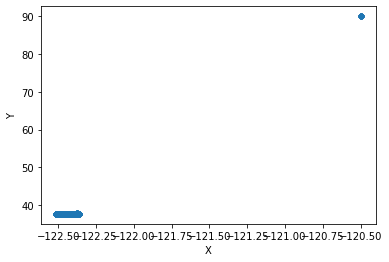

In [33]:
# First, let's visualize the locations of these crimes geographically
%matplotlib inline
criminal = criminal_train.copy()
criminal.plot(kind='scatter', x='X', y='Y', alpha=0.4)
plt.show()

In [34]:
# It looks like there is an error in our training data. Let's remove the row where the latitude is over 60
mask = criminal_train['Y'] < 60
mask2 = graph['Y'] < 60
criminal_train = criminal_train[mask]
graph = graph[mask2]

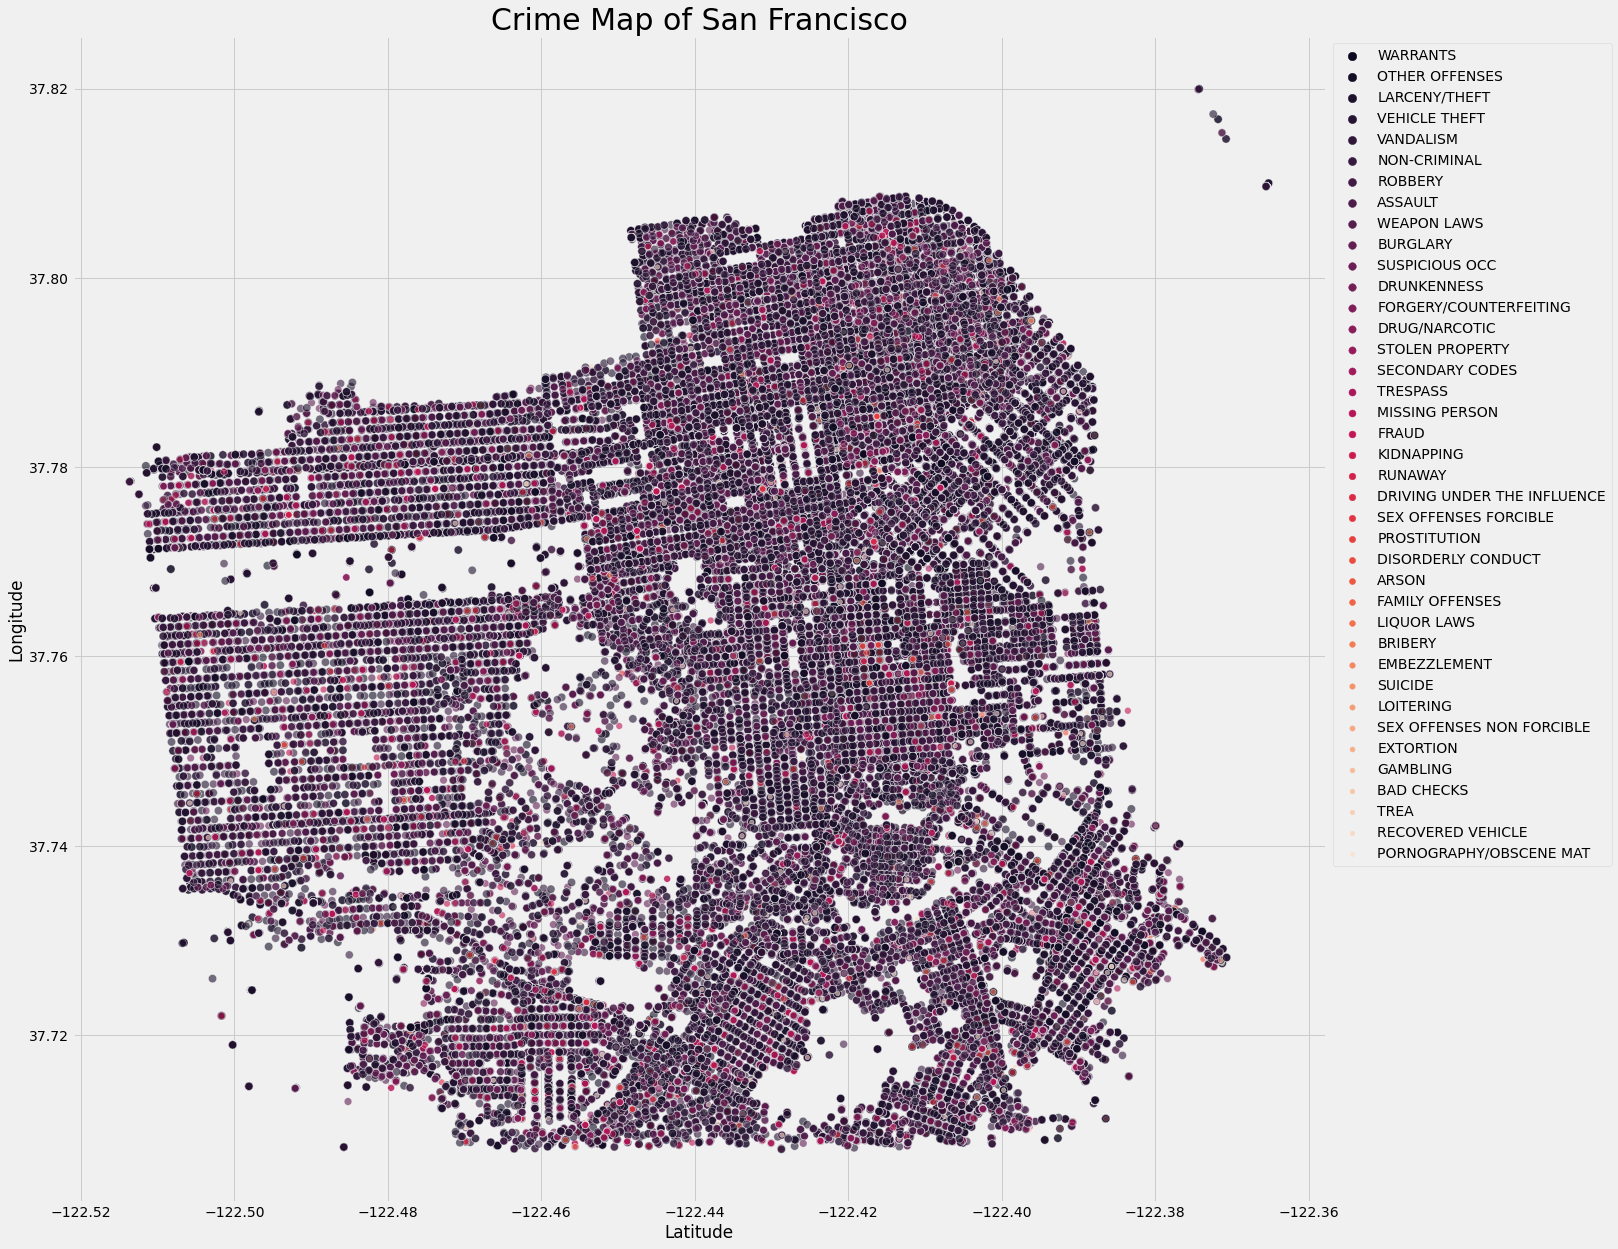

In [35]:
# Let's plot this again, but using a subset of the data to not overburden our graph
%matplotlib inline
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    sns.scatterplot(data=graph.iloc[:265000], x='X', y='Y', alpha=0.6,
                   palette='rocket', hue='Category', size='Category')
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title("Crime Map of San Francisco", fontsize=30)

Wow, this is a very interesting picture. Recall that we have over 878,000 crimes in our dataset. As a result, our picture has over 878,000 dots. Here is what we'll do. Because it looks like the crimes with labels between 0 and 10 are distributed almost evenly throughout the area, I hypothesize that it wouldn't do our model much good to cluster these groups together based upon coordinates. For example, if we had a ton of red dots in the lower left hand corner and a ton of green dots in the upper left, slicing up our X,Y geocoordinates into zones would help tremendously. However, I hypothesize that, because crimes of labels 0-10 appear almost everywhere, it might create unnecessary noise in our data to add this feature. We'll still add it, but depending on the results of the error metric we use, we might look to drop this feature column that we are about to create. 

### Clustering Regions

In [36]:
# We first import our library for KMeans Clustering. Note that since this is a classification project, I won't go through manually creating a clustering algorithm.
# For a manual clustering algorithm, refer to my FIFA Player Classification Project
from sklearn.cluster import KMeans

In [37]:
# We then define our feature matrix for creating a model for our clusters
cluster_features = criminal_train[["X", "Y"]]
Districts = ["SOUTHERN", "MISSION", "NORTHERN", "BAYVIEW", "CENTRAL", "TENDERLOIN", "INGLESIDE", "TARAVAL", "PARK", "RICHMOND"]

In [38]:
# We then scale the x, y coordinates
cluster_features = (cluster_features - cluster_features.min()) / (cluster_features.max() - cluster_features.min())

In [39]:
# We then fit our model to the training data
kmeans = KMeans(5)
kmeans.fit(cluster_features)

KMeans(n_clusters=5)

In [40]:
# We then the cluster each crime is associated with to our criminal training dataframe
criminal_train["Geozone"] = pd.Series(kmeans.labels_)

In [41]:
# We can now drop the geographic locations of our training dataframe
criminal_train = criminal_train.drop(["Address", "X", "Y"], axis=1)

In [42]:
# Now, let's check to see if our new Geozone column has any NaN values
criminal_train['Geozone'].isnull().sum()

59643

In [43]:
# Because our dataset is 878,000 let's just remove these elements
criminal_train.dropna(axis=0, inplace=True)

### Stratified Sampling

A very important thing to note is the distribution of our labels. Notce that Larceny/Theft (label 2) accounts for almost 175,000 of the crimes in our dataset while a crime like Trea (label 36) only accounts for 6. This skew in our distribution will severly affect the accuracy of our modle if we don't do something about it. One solution is to perform stratified sampling. 

In essence, we will try to select an equal amount of elements in our dataset for each label. Now, for the lesser committed crimes, it's quite literally impossible to get say, 1,000 samples because 1,000 samples don't exist. We'll leave those labels be. But for now, let's try to get about 1,500 samples per lable

In [44]:
# We will first random sample by choosing 60% of the values of each category
# criminal_train = criminal_train.groupby("Category", group_keys=False).apply(lambda x: x.sample(frac=0.6))

### Feature and Target Construction

At this point in our pipeline, we are ready to define our feature matrix and target columns. Essentially, this boils down simply defining our Category column as our label and dropping it from our input feature matrix. 

However, an additional component that we will do is implement a cross validation set as well as randomize our training examples since our feature matrix is currently in chronological order.

In [45]:
# We first shuffle our main training matrix to ensure our target column captures the shuffle
np.random.seed(42)
shuffled_index = np.random.permutation(criminal_train.index)
criminal_train = criminal_train.reindex(shuffled_index)

In [46]:
len(criminal_train)

752886

In [47]:
cutoff = int(len(criminal_train) * .80)

In [48]:
# We now split up our data into a typical X and y feature matrix and vector
X = criminal_train.drop("Category", axis=1)
y = criminal_train["Category"]

In [49]:
# We now create a cross validation holdout set. Because there are 878,000 examples, we'll use 50,000 as our cross validation set.
train_X, cv_X = X[:cutoff], X[cutoff:]
train_y, cv_y = y[:cutoff], y[cutoff:]

### Model Construction

Now comes the fun part: the actual construction of our model. Because this is a multiclass classification problem, it is not as simple as simply creating a Logistic Regression model. Recall, such a linear model is binary, namely it can only distinguish at most between 2 distinct classes. However, if we use a "One-vs-Rest" type of method, we could leverage Logistic Regression for this purpose. 

What we will do in this section is create 3 different models: a multiclass Logistic Regression moddel using OvR, a Random Forest Classifier, and a Neural Network using Keras and TensorFlow. We will go one by one through each model and see which one performs best on our cross validation set. We will then submit that one to Kaggle after inputting the test data.

In [50]:
# We first create a function that takes in a base model and trains, predicts, and outputs a score
def model_run(model):
    trained_model = model.fit(train_X, train_y)  # We train our model on our data
    cross = model.predict(cv_X)  # We use our model to generate predictions and store the results
    train = model.predict(train_X)   # We use our model to generate predictions on our test set to see if we are overfitting
    
    cv_acc_score = accuracy_score(cv_y, cross)  # We calculate the cross validation score
    train_acc_score = accuracy_score(train_y, train)  # We calculate the score for the training set
    
    cv_ll = log_loss(cv_y, model.predict_proba(cv_X))  # We then calcualte the log loss of our cv set (metric used by Kaggle)
    train_ll = log_loss(train_y, model.predict_proba(train_X))  # We calculate the same for our training set 
    
    print(f"Our cross validation accuracy score is {round(cv_acc_score, 2) * 100}%")  # We print the result
    print(f"The accuracy for our training predictions is {round(train_acc_score, 2) * 100}%") # We print the result
    print(f"Our log loss score for our cv model is {round(cv_ll, 3)}")  # We print the result
    print(f"Our log loss score for our training set is {round(train_ll, 3)}")  # We print the result
    return trained_model  # We return our trained model so we can use it on the test set

#### Model 1: Multclass Logistic Regression

In [51]:
# We first import the multiclass library to create a "OvR" Logistic Regression model
from sklearn.multiclass import OneVsRestClassifier

In [52]:
# We then create our OvR model
OvR_clf = OneVsRestClassifier(LogisticRegression(max_iter=200))

In [53]:
One_vs_Rest = model_run(OvR_clf)

Our cross validation accuracy score is 23.0%
The accuracy for our training predictions is 23.0%
Our log loss score for our cv model is 2.577
Our log loss score for our training set is 2.578


#### Model 2 : Random Forest

In [54]:
# We create an instance of a random forest classifier
rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16)

In [55]:
RandomForest = model_run(rf)

Our cross validation accuracy score is 23.0%
The accuracy for our training predictions is 23.0%
Our log loss score for our cv model is 2.594
Our log loss score for our training set is 2.595


#### Model 3: Deep Neural Network

In [56]:
from tensorflow import keras

In [57]:
tf_model = keras.models.Sequential()
tf_model.add(keras.layers.Dense(300, activation='relu'))
tf_model.add(keras.layers.Dense(100, activation='relu'))
tf_model.add(keras.layers.Dense(39, activation='softmax'))

In [58]:
tf_model.compile(loss="sparse_categorical_crossentropy", 
             optimizer="sgd",
             metrics=["accuracy"])

In [59]:
history = tf_model.fit(train_X, train_y, epochs=30,
                      validation_data=(cv_X, cv_y))

Epoch 1/30
18823/18823 [==============================] - 16s 854us/step - loss: 2.6266 - accuracy: 0.2279 - val_loss: 2.5945 - val_accuracy: 0.2298
Epoch 2/30
18823/18823 [==============================] - 17s 878us/step - loss: 2.5897 - accuracy: 0.2313 - val_loss: 2.5881 - val_accuracy: 0.2313
Epoch 3/30
18823/18823 [==============================] - 17s 880us/step - loss: 2.5838 - accuracy: 0.2320 - val_loss: 2.5830 - val_accuracy: 0.2324
Epoch 4/30
18823/18823 [==============================] - 16s 870us/step - loss: 2.5807 - accuracy: 0.2324 - val_loss: 2.5790 - val_accuracy: 0.2322
Epoch 5/30
18823/18823 [==============================] - 17s 928us/step - loss: 2.5786 - accuracy: 0.2328 - val_loss: 2.5822 - val_accuracy: 0.2309
Epoch 6/30
18823/18823 [==============================] - 17s 919us/step - loss: 2.5772 - accuracy: 0.2330 - val_loss: 2.5748 - val_accuracy: 0.2330
Epoch 7/30
18823/18823 [==============================] - 17s 928us/step - loss: 2.5759 - accuracy: 0.2332

### Preparing the Test Set

We have now trained our model on the training set. We're confident at this point that our model is not underfitting or overfitting. Thus we have a good bias, variance balance. We now apply all of the same transformations to our test set that we performed on the training set.

In [60]:
# Datetime conversion
criminal_test["Dates"] = pd.to_datetime(criminal_test["Dates"])

In [61]:
# Create the dummy police columns
police_columns2 = pd.get_dummies(criminal_test["PdDistrict"])
criminal_test = pd.concat([criminal_test.copy(), police_columns2], axis=1)
criminal_test = criminal_test.drop("PdDistrict", axis=1)

In [62]:
# Create the dummies for the week column
days_columns2 = pd.get_dummies(criminal_test["DayOfWeek"])
criminal_test = pd.concat([criminal_test, days_columns2], axis=1)
criminal_test = criminal_test.drop('DayOfWeek', axis=1)

In [63]:
# We now create our midnight column
criminal_test["Year"] = criminal_test["Dates"].dt.year
year_columns2 = pd.get_dummies(criminal_test["Year"])
criminal_test = pd.concat([criminal_test, year_columns2], axis=1)
criminal_test["Midnight"] = criminal_test["Dates"].apply(midnight)
criminal_test = criminal_test.drop(["Dates", "Year"], axis=1)
criminal_test.rename(columns=year_map, inplace=True)

In [64]:
# We then perform our clustering algorithm
cluster_features2 = criminal_test[["X", "Y"]]

# We then scale the x, y coordinates
cluster_features2 = (cluster_features2 - cluster_features2.min()) / (cluster_features2.max() - cluster_features2.min())

# We then perform clustering
kmeans2 = KMeans(5)
kmeans2.fit(cluster_features2)

criminal_test["Geozone"] = pd.Series(kmeans2.labels_)
criminal_test = criminal_test.drop(["Address", "X", "Y"], axis=1)

### Leveraging our Test models

In [65]:
ids = criminal_test["Id"]
criminal_test.drop("Id", axis=1, inplace=True)

In [66]:
One_vs_Rest_probs = One_vs_Rest.predict_proba(criminal_test)

In [67]:
OvR_df = pd.DataFrame(One_vs_Rest_probs, index=ids)

In [68]:
reversed_crime_map = {}
for key, value in crime_map.items():
    reversed_crime_map[value] = key

In [69]:
OvR_df.rename(mapper=reversed_crime_map, axis=1, inplace=True)

In [70]:
OvR_df = OvR_df.reindex(sorted(OvR_df.columns), axis=1)

In [71]:
OvR_df.head()

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Id,,,,,,,,,,,,,,,,,,,,,
0,0.013759,0.130942,0.000028,0.001472,0.032177,0.001444,0.006178,0.012838,0.006035,0.000373,...,0.000156,0.004668,0.000183,0.041125,0.000005,0.004887,0.086247,0.081045,0.036126,0.021740
1,0.013759,0.130942,0.000028,0.001472,0.032177,0.001444,0.006178,0.012838,0.006035,0.000373,...,0.000156,0.004668,0.000183,0.041125,0.000005,0.004887,0.086247,0.081045,0.036126,0.021740
2,0.003422,0.094278,0.000051,0.000384,0.039861,0.001958,0.007019,0.010892,0.006450,0.000510,...,0.000103,0.006999,0.000328,0.027039,0.000005,0.004959,0.068797,0.055796,0.031972,0.008145
3,0.005529,0.121353,0.000029,0.001534,0.030403,0.001313,0.007240,0.007061,0.004452,0.000293,...,0.000214,0.004072,0.000387,0.035265,0.000002,0.003544,0.090957,0.112413,0.022472,0.016240
4,0.005529,0.121353,0.000029,0.001534,0.030403,0.001313,0.007240,0.007061,0.004452,0.000293,...,0.000214,0.004072,0.000387,0.035265,0.000002,0.003544,0.090957,0.112413,0.022472,0.016240


In [72]:
# We then write our dataframe to a csv file to upload to kaggle. I've commented it out because it is 750MB.
# OvR_df.to_csv('One_vs_Rest_Results.csv')

In [73]:
# We then perform the same operation for our Random Forest Model
rf_probs = rf.predict_proba(criminal_test)
rf_df = pd.DataFrame(rf_probs, index=ids).rename(mapper=reversed_crime_map, axis=1)
rf_df = rf_df.reindex(sorted(rf_df.columns), axis=1)

In [74]:
# rf_df.to_csv("Random_Forest_Results.csv")

In [89]:
# Our Neural Network will take a slightly different route to format to upload to Kaggle.
nn_proba = tf_model.predict(criminal_test)
nn_df = pd.DataFrame(nn_proba, index=ids)

27634/27634 [==============================] - 19s 690us/step


In [90]:
nn_df.rename(mapper=reversed_crime_map, axis=1, inplace=True)

In [91]:
nn_df = nn_df.reindex(sorted(nn_df.columns), axis=1)

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Id,,,,,,,,,,,,,,,,,,,,,
0,0.010451,0.120406,0.000095,0.000383,0.044393,0.001333,0.005888,0.016130,0.004263,0.000411,...,0.000114,0.004273,0.000433,0.039950,0.000009,0.005644,0.072245,0.077280,0.037322,0.018381
1,0.010451,0.120406,0.000095,0.000383,0.044393,0.001333,0.005888,0.016130,0.004263,0.000411,...,0.000114,0.004273,0.000433,0.039950,0.000009,0.005644,0.072245,0.077280,0.037322,0.018381
2,0.002763,0.106815,0.000118,0.000231,0.064375,0.003099,0.004920,0.010494,0.005808,0.000686,...,0.000065,0.005657,0.000344,0.027277,0.000011,0.006690,0.069832,0.041837,0.031009,0.007802
3,0.003984,0.130929,0.000107,0.000369,0.033497,0.001342,0.005300,0.010521,0.003751,0.000406,...,0.000110,0.004094,0.000386,0.032831,0.000009,0.004464,0.078566,0.103242,0.028645,0.014831
4,0.003984,0.130929,0.000107,0.000369,0.033497,0.001342,0.005300,0.010521,0.003751,0.000406,...,0.000110,0.004094,0.000386,0.032831,0.000009,0.004464,0.078566,0.103242,0.028645,0.014831


In [97]:
# nn_df.to_csv("Neural_Network.csv")

## Conclusion

For this project, we were able to perform some feature analysis and create 3 multiclass classification models to predict what type of crime a delinquent would commit based upon the limited set of features that were given to us. The Kaggle competition that we submitted to scores the submissions by multiclass logarithmic loss. Here are the results of our models on the test sets:

1. Neural Network: 2.58784
2. One vs Rest Classifier: 2.59276
3. Random Forest Model: 2.61383

There are definitely improvements that we can make to our Neural Network model. We could use an additional layer or more neurons per layer. I might come back and address this at a later time. For now, this Neural Network Model is good enough to rank 1138th out of 2238 in the competition. Not too bad!